In [15]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torch.distributions


import numpy as np
import matplotlib.pyplot as plt

In [155]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()        
        
         ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )        
        
        ### Linear section: mean
        self.encoder_mean = nn.Sequential(
            nn.Linear(3 * 3 * 32, 100),
            nn.ReLU(True),
            nn.Linear(100, latent_dims)
        )
        
        ### Linear section: std
        self.encoder_std = nn.Sequential(
            nn.Linear(3 * 3 * 32, 100),            
            nn.ReLU(True),
            nn.Linear(100, latent_dims)
        )   

    def forward(self, x):
        ### CNN
        x = self.encoder_cnn(x)     
        x = x.view(x.size(0), -1)  
        
        ### MLP
        mu = self.encoder_mean(x)  
        sigma = self.encoder_std(x)
        return mu, sigma     

In [156]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        
        ### linear decoder
        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims, 100),
            nn.ReLU(True),
            nn.Linear(100, 3 * 3 * 32),
        )        

        ### deconcv layer
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, z):
        z = self.decoder_lin(z)
        z = z.view(z.size(0), 32, 3, 3)
        z = self.decoder_conv(z)
        z = torch.sigmoid(z)
        return z

In [157]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)
        
    def reparametrization_trick(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparametrization_trick(mu, logvar)
        return self.decoder(z), mu, logvar    

In [161]:
### Cost function
def criterion(recon_x, x, mu, logvar):
    ### reconstruction loss
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
#     recon_loss = nn.MSELoss(recon_x, x, reduction='sum')

    ### KL divergence loss
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    ### total loss
    loss = recon_loss + kld_loss
    return loss

### Train function
def train(vae, train_loader, criterion, optimizer, device, epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)
        loss = criterion(recon_batch, data, mu, logvar)
        loss.backward()

        optimizer.step()
        train_loss += loss.item()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

### Test Function
def test(vae, test_loader, criterion, device):
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in data_test:
            data = data.to(device)
            recon_batch, mu, log_var = vae(data)
            
            ### sum up batch loss
            loss = criterion(recon_batch, data, mu, logvar)
            test_loss += loss.item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [162]:
### Load MNIST Dataset\n",
data_train = DataLoader(MNIST('./data', train=True, download=True, transform=ToTensor()),
                        batch_size=128, shuffle=False)
data_test = DataLoader(MNIST('./data', train=False, download=True, transform=ToTensor()),
                        batch_size=128, shuffle=False, drop_last=True)

In [163]:
### Init and Train Model
latent_dims = 15
device = 'cuda' if torch.cuda.is_available() else 'cpu'
vae = VariationalAutoencoder(latent_dims).to(device)
opt = optim.Adam(vae.parameters())

for epoch in range(1, 5):
    train(vae, data_train, criterion, opt, device, epoch)
    test(vae, data_test, criterion, device)


Train Epoch: 1 [0/60000 (0%)]	Loss: 591.888489
Train Epoch: 1 [12800/60000 (21%)]	Loss: 321.113922
Train Epoch: 1 [25600/60000 (43%)]	Loss: 251.086182
Train Epoch: 1 [38400/60000 (64%)]	Loss: 205.285645
Train Epoch: 1 [51200/60000 (85%)]	Loss: 193.868103
====> Epoch: 1 Average loss: 265.7477
====> Test set loss: 180.6828
Train Epoch: 2 [0/60000 (0%)]	Loss: 174.914154
Train Epoch: 2 [12800/60000 (21%)]	Loss: 164.042252
Train Epoch: 2 [25600/60000 (43%)]	Loss: 164.578735
Train Epoch: 2 [38400/60000 (64%)]	Loss: 150.064484
Train Epoch: 2 [51200/60000 (85%)]	Loss: 159.687424
====> Epoch: 2 Average loss: 161.1430
====> Test set loss: 150.6566
Train Epoch: 3 [0/60000 (0%)]	Loss: 147.387436
Train Epoch: 3 [12800/60000 (21%)]	Loss: 144.782684
Train Epoch: 3 [25600/60000 (43%)]	Loss: 148.199188
Train Epoch: 3 [38400/60000 (64%)]	Loss: 136.198471
Train Epoch: 3 [51200/60000 (85%)]	Loss: 147.128296
====> Epoch: 3 Average loss: 144.9970
====> Test set loss: 137.7783
Train Epoch: 4 [0/60000 (0%)]	L

In [196]:
def generate_images(vae,latent_dims, device, n_images=1):
    ### Generate random latent variables
    z = torch.randn(n_images, latent_dims).to(device)
    
    #### Reconstruct images from latent variables
    recon_images = vae.decoder(z)
    return recon_images

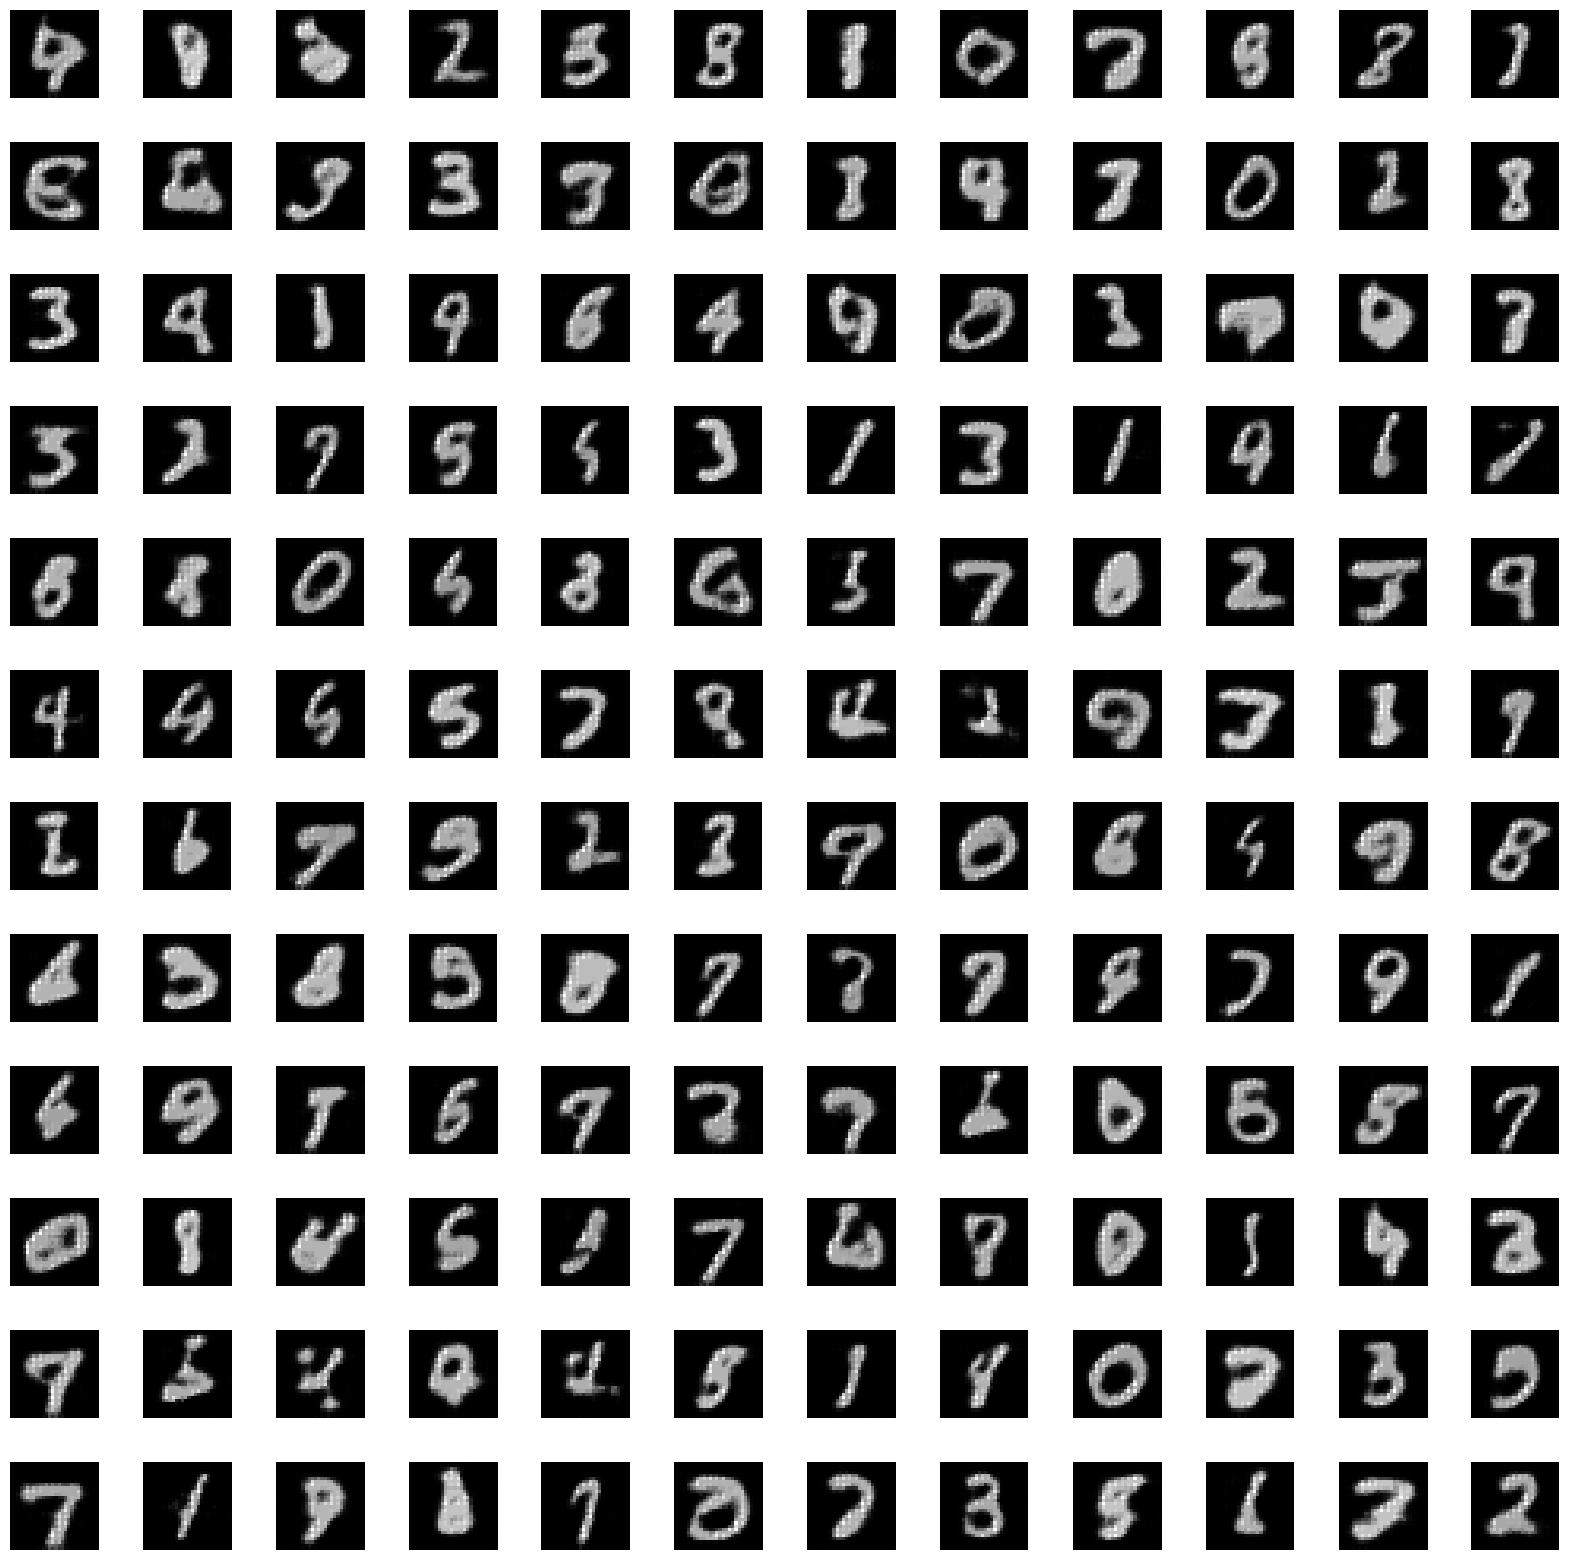

In [198]:
vae.eval()

#### Generate images
n_images = 144
recon_images = generate_images(vae, latent_dims, device, n_images)

#### Convert images to numpy and denormalize them
recon_images = recon_images.detach().cpu().numpy()
recon_images = (recon_images + 1)/2

#### Plot images
fig, axs = plt.subplots(12,12, figsize=(20, 20))
fig.subplots_adjust(hspace = .5, wspace=.5)
axs = axs.ravel()
for i in range(144):
    axs[i].imshow(recon_images[i][0], cmap = 'gray')
    axs[i].axis('off')

In [111]:
### Plot Latent space
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        x, mu, std = autoencoder(x.to(device))
        z = autoencoder.reparametrization_trick(mu, std)
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

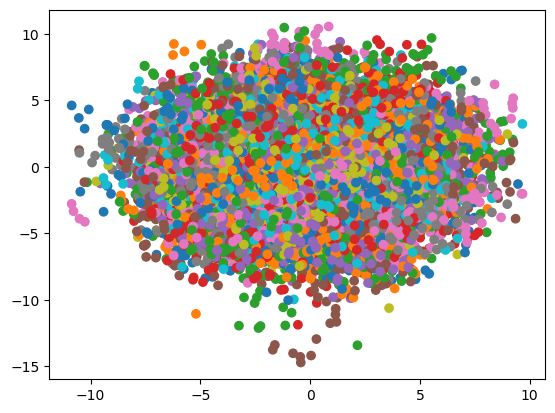

In [170]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
for i, (data, label) in enumerate(data_test):
    data = data.to(device)
    mu, logvar = vae.encoder(data)
    z = vae.reparametrization_trick(mu, logvar)
    latent_vars_2d = tsne.fit_transform(z.detach().cpu().numpy())
    plt.scatter(latent_vars_2d[:, 0], latent_vars_2d[:, 1], c=label, cmap='tab10')
    if i > 100:
        plt.colorbar()
        break